In [109]:
from IPython.display import Image
WumpusWorld = Image(filename='../Images/Wumpus.png')

# 🐑 Penyelesaian Praktikum Wumpus 🐑

Nama : Aidin Ferarista Zakariyah
NRP  : 5054231025

Di Notebook kali ini, saya akan menyelesaikan games Wumpus_World:

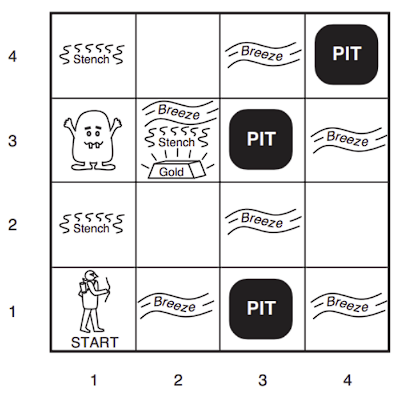

In [110]:
WumpusWorld

Kita akan membuat beberapa proposisi (aturan) R1 hingga Rn secara berurutan dan bertahap berdasarkan aturan **Wumpus World**, dimulai dari koordinat agen [1,1] hingga agen berhasil mendapatkan emas di koordinat [2,3] dengan selamat.

In [111]:
from logic import *
from utils import *
from notebook import psource
import pandas as pd

## Initiating Function

Kita akan menginisiasi beberapa fungsi yang telah dimodifikasi untuk juga dapat dibentuk DataFramenya

In [112]:
def pl_true(exp, model={}):
    """
    Mengembalikan True jika ekspresi logika proposisional bernilai benar dalam model,
    dan False jika bernilai salah. Jika model tidak menentukan nilai untuk setiap proposisi,
    fungsi ini dapat mengembalikan None untuk menunjukkan bahwa nilainya 'tidak jelas'.
    Hal ini mungkin terjadi bahkan jika ekspresi merupakan tautologi.

    Parameter:
    
    - exp: Ekspresi logika proposisional yang akan dievaluasi. Ekspresi ini bisa berupa simbol proposisional,
           nilai boolean (True atau False), atau operator logika proposisional seperti & (dan), | (atau),
           ~ (negasi), ==> (implikasi), <=> (ekuivalensi), dan lainnya.
    - model: Sebuah dictionary yang memetakan simbol proposisional ke nilai boolean (True atau False).
             Jika model tidak memberikan nilai untuk suatu simbol dalam ekspresi, fungsi ini dapat 
             mengembalikan None untuk menunjukkan bahwa nilai proposisi tidak dapat dipastikan.

    Contoh penggunaan:
    
    >>> pl_true(P, {}) is None
    True

    >>> pl_true(P & Q, {P: True, Q: False})
    False

    >>> pl_true(P ==> Q, {P: True, Q: True})
    True
    """
    
    if exp in (True, False):
        return exp
    op, args = exp.op, exp.args
    if is_prop_symbol(op):
        return model.get(exp)
    elif op == '~':
        p = pl_true(args[0], model)
        if p is None:
            return None
        else:
            return not p
    elif op == '|':
        result = False

        for arg in args:
            p = pl_true(arg, model)
            if p is True:
                return True
            if p is None:
                result = None
        return result
    elif op == '&':
        result = True
        for arg in args:
            p = pl_true(arg, model)
            if p is False:
                return False
            if p is None:
                result = None
        return result
    p, q = args
    if op == '==>':
        return pl_true(~p | q, model)
    elif op == '<==':
        return pl_true(p | ~q, model)
    pt = pl_true(p, model)
    if pt is None:
        return None
    qt = pl_true(q, model)
    if qt is None:
        return None
    if op == '<=>':
        return pt == qt
    elif op == '^':  # xor or 'not equivalent'
        return pt != qt
    else:
        raise ValueError('Illegal operator in logic expression' + str(exp))

In [113]:
def tt_check_all(kb, alpha, symbols, model, results_list):
    """
    Fungsi pendukung untuk mengimplementasikan tt_entails. 
    Fungsi ini memeriksa semua kemungkinan model dengan metode tableaus kebenaran (truth table)
    untuk menentukan apakah sebuah ekspresi (alpha) dijamin benar berdasarkan knowledge base (KB).

    Parameter:
    
    - kb: Knowledge base (KB) atau basis pengetahuan dalam bentuk ekspresi logika proposisional yang akan diuji kebenarannya.
    - alpha: Ekspresi logika proposisional yang ingin diuji apakah dijamin benar oleh KB.
    - symbols: Daftar simbol proposisional yang akan digunakan untuk diperiksa dalam truth table.
    - model: Dictionary yang merepresentasikan model saat ini, yaitu penetapan nilai-nilai True atau False pada simbol proposisional.
    - results_list: Sebuah list untuk menyimpan semua model yang telah diuji. Setiap model yang diuji ditambahkan ke list ini dengan status KB (benar atau salah).

    Contoh Penggunaan:
    
    Memeriksa apakah alpha dijamin benar dalam semua model berdasarkan KB:
    >>> tt_check_all(kb, alpha, symbols, {}, [])
    True atau False
    """
    if not symbols:
        # Mengembalikan True jika ekspresi logika proposisional bernilai benar dalam model sesuai dengan KB
        if pl_true(kb, model):
            result = pl_true(alpha, model)
            assert result in (True, False)

            model['kb'] = True
            results_list.append(model)
            return result
        else:
            result_info = f"KB false, Model: {model}"
            model['kb'] = False
            results_list.append(model)
            return True
    else:
        P, rest = symbols[0], symbols[1:]

        true_result= tt_check_all(kb, alpha, rest, extend(model, P, True), results_list)
        false_result= tt_check_all(kb, alpha, rest, extend(model, P, False), results_list)

        return (true_result and false_result)

In [114]:
def tt_entails(kb, alpha):
    """
    Memeriksa apakah KB (knowledge base) mengimplikasikan kalimat proposisional alpha dengan menggunakan tabel kebenaran.
    Fungsi ini berlaku untuk KB dan kalimat proposisional yang direpresentasikan sebagai ekspresi logika proposisional.
    'kb' harus berupa sebuah ekspresi yang merupakan konjungsi dari klausa-klausa.

    Parameter:
    
    - kb: Knowledge base atau basis pengetahuan berupa ekspresi logika proposisional yang akan diuji.
    - alpha: Kalimat proposisional yang akan diuji apakah dijamin benar oleh KB (apakah KB mengimplikasikan alpha).

    Fungsi ini memeriksa semua kemungkinan penugasan nilai kebenaran (truth table) untuk simbol-simbol yang ada dalam KB dan alpha,
    dan memastikan bahwa jika KB benar, maka alpha juga harus benar.

    Contoh Penggunaan:
    
    # Memeriksa apakah alpha dijamin benar dalam semua model berdasarkan KB:
    >>> tt_entails(kb, alpha)
    (True, [{...}, {...}, ...])
    """
    # Mengembalikan sebuah set yang berisi variabel-varible dalam ekspresi
    assert not variables(alpha)

    # Mengambil semua simbol proposisional (variabel) dari KB dan kalimat alpha
    symbols = list(prop_symbols(kb & alpha))

    print(f"Symbols: {symbols}")
    print(f"KB: {kb}\n")
    print(f"Alpha: {alpha}")
    print('-' * 20)

    # Menyimpan semua hasil truth table yang mungkin
    results_list = []

    # Memanggil fungsi tt_check_all untuk memeriksa apakah kb mengimplikasikan alpha.
    # Fungsi ini akan memeriksa setiap penugasan kebenaran untuk simbol-simbol tersebut,
    # memastikan bahwa jika kb benar, maka alpha juga harus benar.
    # {} adalah model awal yang kosong, tanpa penugasan variabel.
    hasil = tt_check_all(kb, alpha, symbols, {}, results_list)

    print(f"Final result: {hasil}")

    return hasil, results_list

## Going on an Adventure
Setelah semua fungsi telah siap, kita akan mulai memainkan game Wumpus World ini dengan cara

### Menginisasi beberapa rule awal, berdasarkan posisi agent di [1,1]

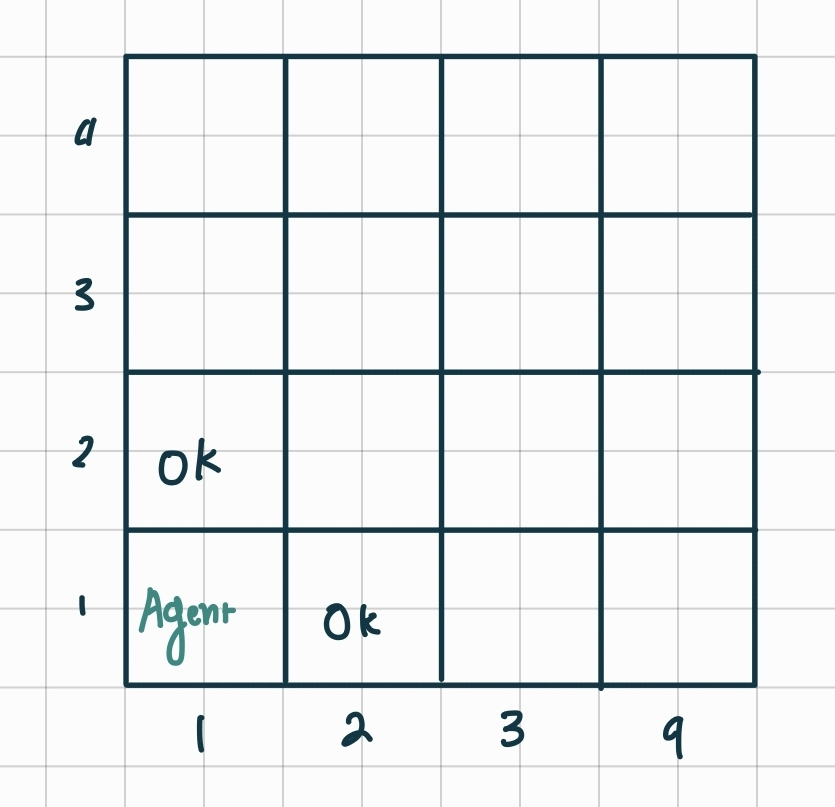

In [115]:
A11 = Image(filename='../Images/A11.jpg', width=200, height=200)
display(A11)

Berdasarkan gambar diatas di sekeliling [1,1] aman, karena agent tidak merasakan apa-apa.

### Kemudian Agent akan bergerak ke [2.1].

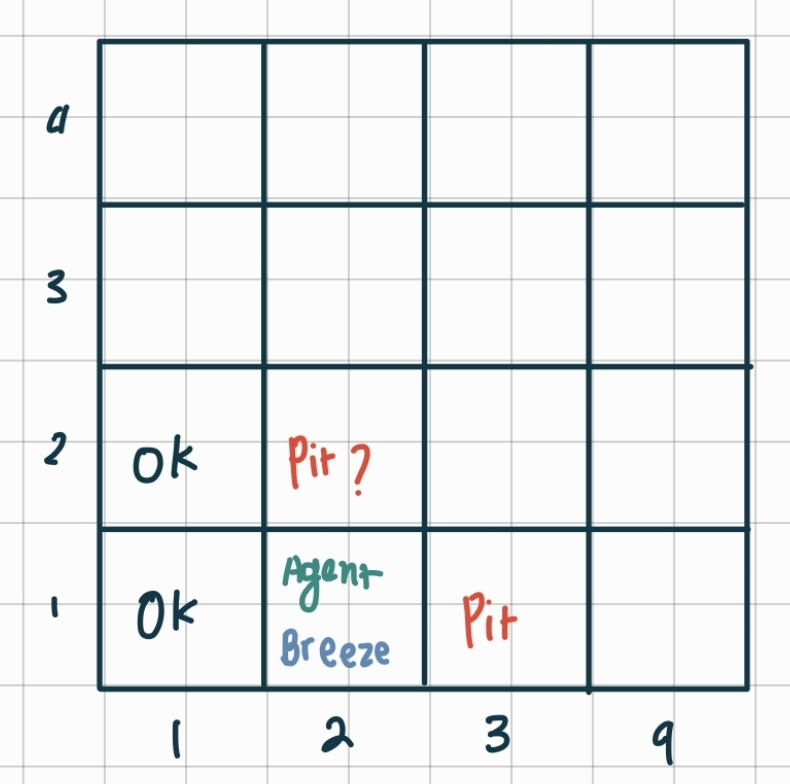

In [116]:
A21 = Image(filename='../Images/A21.jpg', width=200, height=200)
display(A21)

Di [2,1] Agent merasakan sesuatu (Breeze), yang berarti ada pit antara [3,1] atau [2,2].

#### Membuat beberapa proposisi terhadap kondisi tersebut

In [117]:
P11, B21, P22, P31 = expr('P11, B21, P22, P31')

In [118]:
R1 = (B21 |'<=>'| P11 | P22 |P31)
R1

(((B21 <=> P11) | P22) | P31)

In [119]:
R2 = B21
R3 = ~ P11

### Lakukan Checking menggunakan `tt_entails` terhadap P31

In [120]:
is_P31 = pd.DataFrame(tt_entails(R1 & R2 & R3, P31)[1])
is_P31

Symbols: [P22, P31, B21, P11]
KB: (((((B21 <=> P11) | P22) | P31) & B21) & ~P11)

Alpha: P31
--------------------
Final result: False


,P22,P31,B21,P11,kb
0,True,True,True,True,False
1,True,True,True,False,True
2,True,True,False,True,False
3,True,True,False,False,False
4,True,False,True,True,False
5,True,False,True,False,True
6,True,False,False,True,False
7,True,False,False,False,False
8,False,True,True,True,False
9,False,True,True,False,True


Dari beberapa proposisi diatas, kita lihat mana yang kb-nya bernilai True, yakni sebagai berikut:

In [121]:
is_P31[is_P31['kb'] == True]

,P22,P31,B21,P11,kb
1,True,True,True,False,True
5,True,False,True,False,True
9,False,True,True,False,True


Karena masih ada 3 kemungkinan, maka agent masih belum yakin apakah di [3,1] ada pit atau tidak.

### Lakukan checking menggunakan `tt_entails` terhadap [2,2]

In [122]:
is_P22 = pd.DataFrame(tt_entails(R1 & R2 & R3, P22)[1])
is_P22

Symbols: [P22, P31, B21, P11]
KB: (((((B21 <=> P11) | P22) | P31) & B21) & ~P11)

Alpha: P22
--------------------
Final result: False


,P22,P31,B21,P11,kb
0,True,True,True,True,False
1,True,True,True,False,True
2,True,True,False,True,False
3,True,True,False,False,False
4,True,False,True,True,False
5,True,False,True,False,True
6,True,False,False,True,False
7,True,False,False,False,False
8,False,True,True,True,False
9,False,True,True,False,True


In [123]:
is_P22[is_P22['kb'] == True]

,P22,P31,B21,P11,kb
1,True,True,True,False,True
5,True,False,True,False,True
9,False,True,True,False,True


Sama seperti di [3,1], masih ada 3 kemungkinan dimana `kb == true`. Maka dapat disimpulkan Agent belum bisa menyimpulkan apakah di [2,2] ada pit atau tidak.

Maka:
Agent akan kembali ke [1,1] dan menuju ke [1,2].

### Agent pergi ke [1,2]

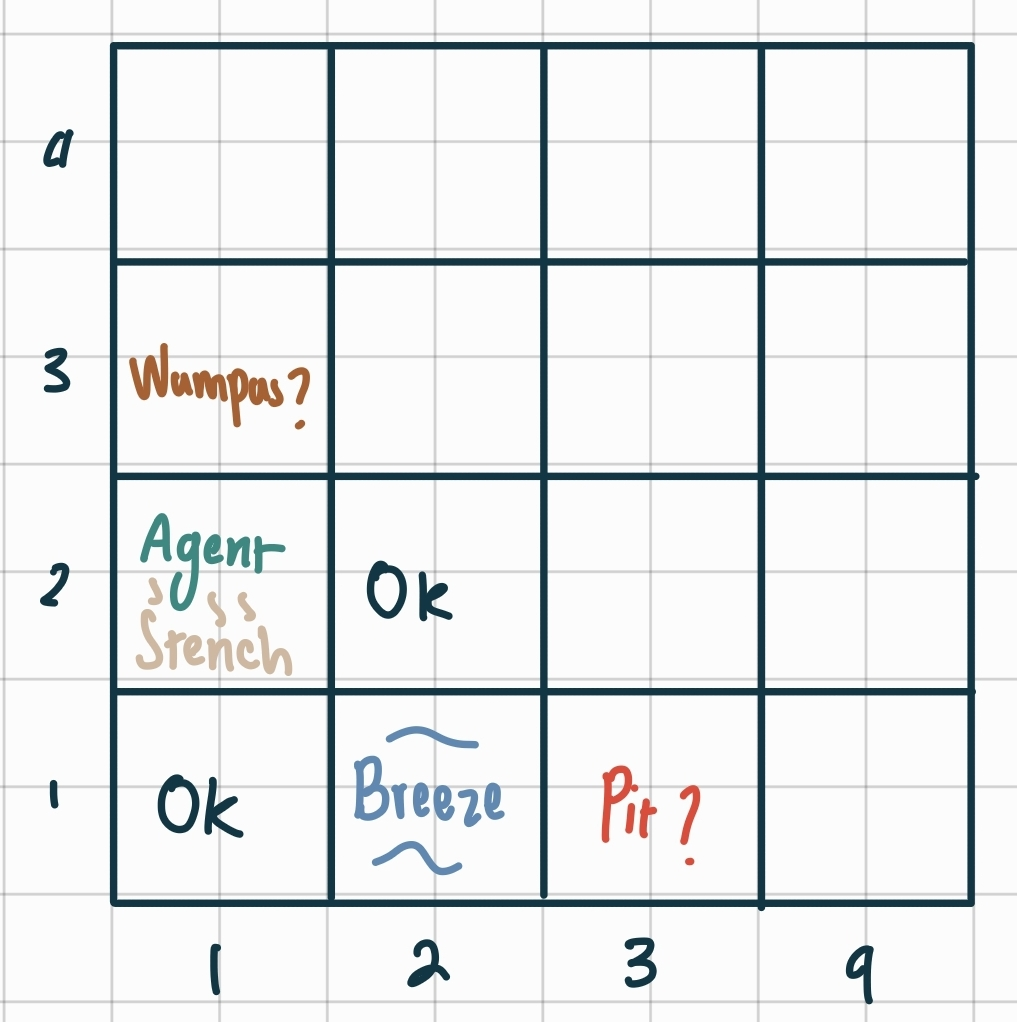

In [124]:
A12 = Image(filename='../Images/A12.jpg', width=200, height=200)
display(A12)

**Pit?**

Seperti yang digambarkan diatas, karena di [1,2] Agent hanya merasakan Stench, maka dapat dipastikan di [2,1] tidak terdapat Pit.

**Wumpus?**

Di [1,2] Agent merasakan Stench, maka ada kemungkina bahwa ada Wumpus diantara [2,2] dan/atau [1,3]. Namun, dapat dipastikan di [2,2] tidak ada Wumpus, karena Agent tidak merasakan Stench di [2,1].

Kesimpulan:
* [2,2] Aman

### Membuat beberapa proposisi terhadap kondisi diatas

In [125]:
S12, W22, W13, W11 = expr('S12, W22, W13, W11')

In [126]:
R4 = (S12 |'<=>'| W22 | W13 | W11)
R5 = S12
R6 = ~W11
R7 = ~P22
R8 = ~W22

### Lakukan checking terhadap [3,1]

In [127]:
is_P31 = pd.DataFrame(tt_entails(R1 & R2 & R3 & R4  & R5 & R6 & R7 & R8,P31)[1])
is_P31

Symbols: [P22, P31, W13, B21, P11, S12, W11, W22]
KB: ((((((((((B21 <=> P11) | P22) | P31) & B21) & ~P11) & (((S12 <=> W22) | W13) | W11)) & S12) & ~W11) & ~P22) & ~W22)

Alpha: P31
--------------------
Final result: True


,P22,P31,W13,B21,P11,S12,W11,W22,kb
0,True,True,True,True,True,True,True,True,False
1,True,True,True,True,True,True,True,False,False
2,True,True,True,True,True,True,False,True,False
3,True,True,True,True,True,True,False,False,False
4,True,True,True,True,True,False,True,True,False
...,...,...,...,...,...,...,...,...,...
251,False,False,False,False,False,True,False,False,False
252,False,False,False,False,False,False,True,True,False
253,False,False,False,False,False,False,True,False,False
254,False,False,False,False,False,False,False,True,False


In [128]:
is_P31[is_P31['kb'] == True]

,P22,P31,W13,B21,P11,S12,W11,W22,kb
139,False,True,True,True,False,True,False,False,True


Karena sudah dapat dipastikan bahwa [2,2] tidak ada Pit, maka satu-satunya kb yang bernilai True adalah saat Pit di [3,1]

### Lakukan checking menggunakan `tt_entails` terhadap [1,3]

In [129]:
is_W13 = pd.DataFrame(tt_entails(R1 & R2 & R3 & R4  & R5 & R6 & R7 & R8,W13)[1])
is_W13

Symbols: [P22, P31, W13, B21, P11, S12, W11, W22]
KB: ((((((((((B21 <=> P11) | P22) | P31) & B21) & ~P11) & (((S12 <=> W22) | W13) | W11)) & S12) & ~W11) & ~P22) & ~W22)

Alpha: W13
--------------------
Final result: True


,P22,P31,W13,B21,P11,S12,W11,W22,kb
0,True,True,True,True,True,True,True,True,False
1,True,True,True,True,True,True,True,False,False
2,True,True,True,True,True,True,False,True,False
3,True,True,True,True,True,True,False,False,False
4,True,True,True,True,True,False,True,True,False
...,...,...,...,...,...,...,...,...,...
251,False,False,False,False,False,True,False,False,False
252,False,False,False,False,False,False,True,True,False
253,False,False,False,False,False,False,True,False,False
254,False,False,False,False,False,False,False,True,False


In [130]:
is_W13[is_W13['kb'] == True]

,P22,P31,W13,B21,P11,S12,W11,W22,kb
139,False,True,True,True,False,True,False,False,True


Karena hanya ada Stench di [1,2] maka satu-satunya kemungkinan dimana ada Wumpus adalah di [1,3]

### Karena dapat dipastikan di [2,2] aman, maka Agent akan bergerak ke sana

Setelah bergerak ke [2,2] Agent tidak merasakan apa-apa. Maka dapat dipastikan di [3,2] dan [2,3] aman.

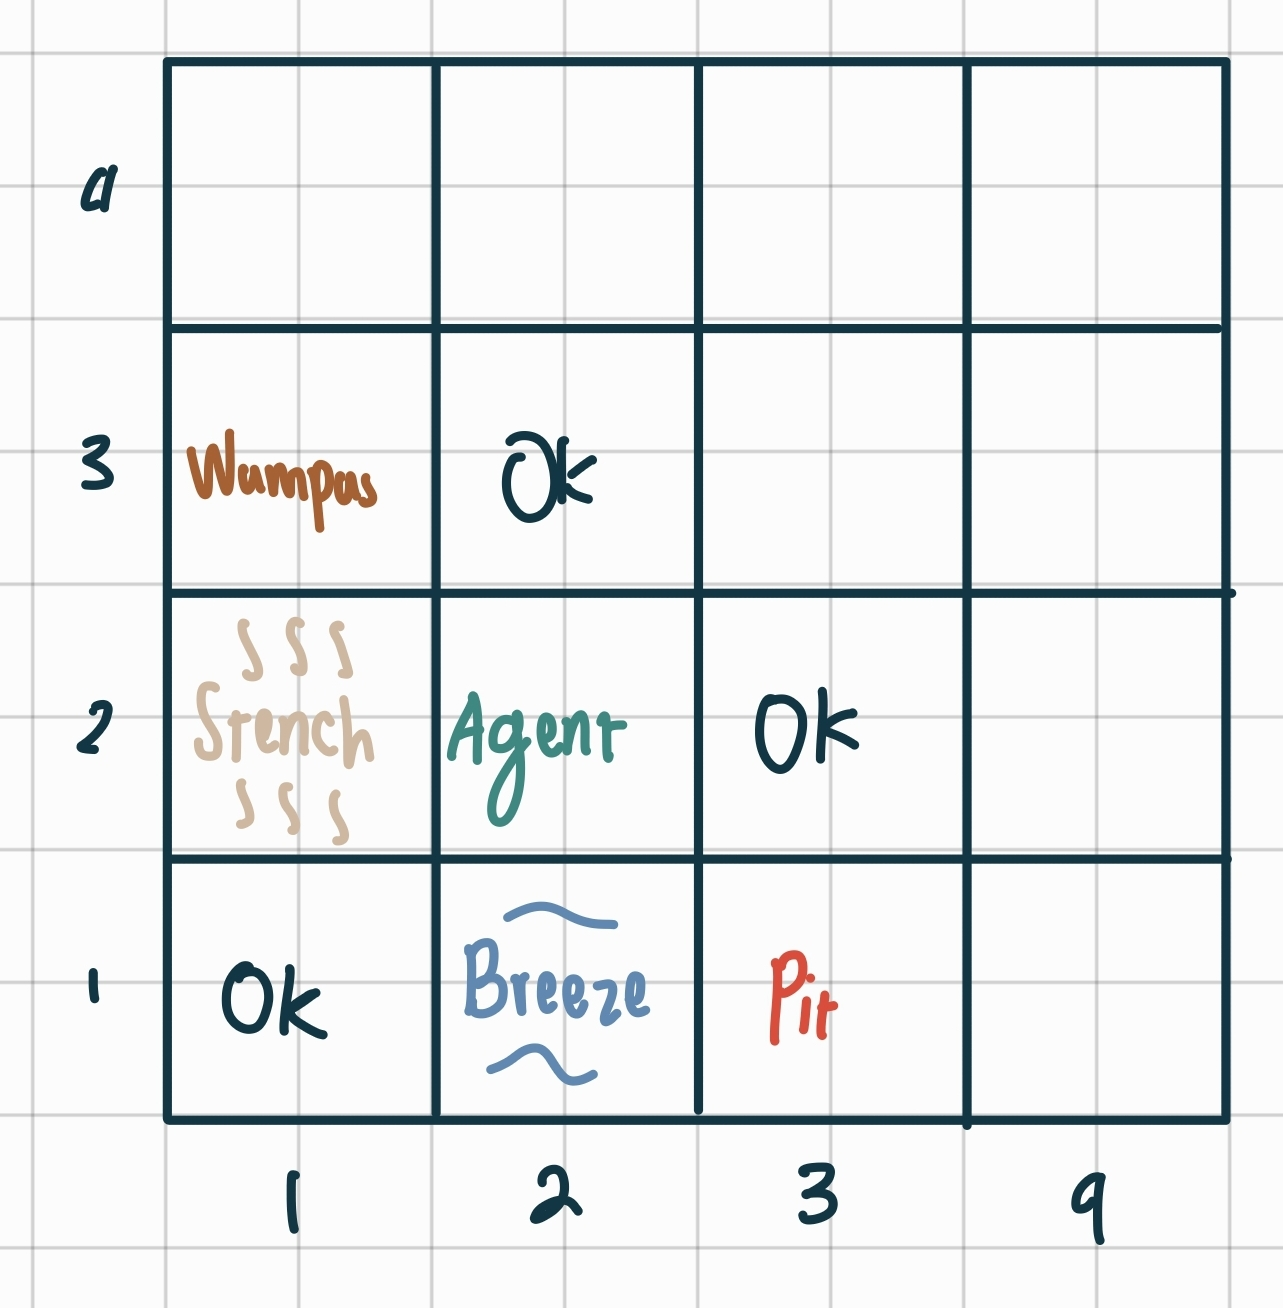

In [131]:
A22 = Image(filename='../Images/A22.jpg', width=200, height=200)
display(A22)

### Agent bergerak ke [2,3].

Setelah berkerak ke [2,3] Agent merasakan semua hal (Breeze dan Stench), namun yang terpentik adalah di sana ia merasakan suatu benda yang keras di kakinya. Ternyata oh ternyata ia menginjak tumpukan emas yang terkubur tipis di bawah tanah. Akhirnya ia senang dan mengakhiri perjalanannya. Selesai...

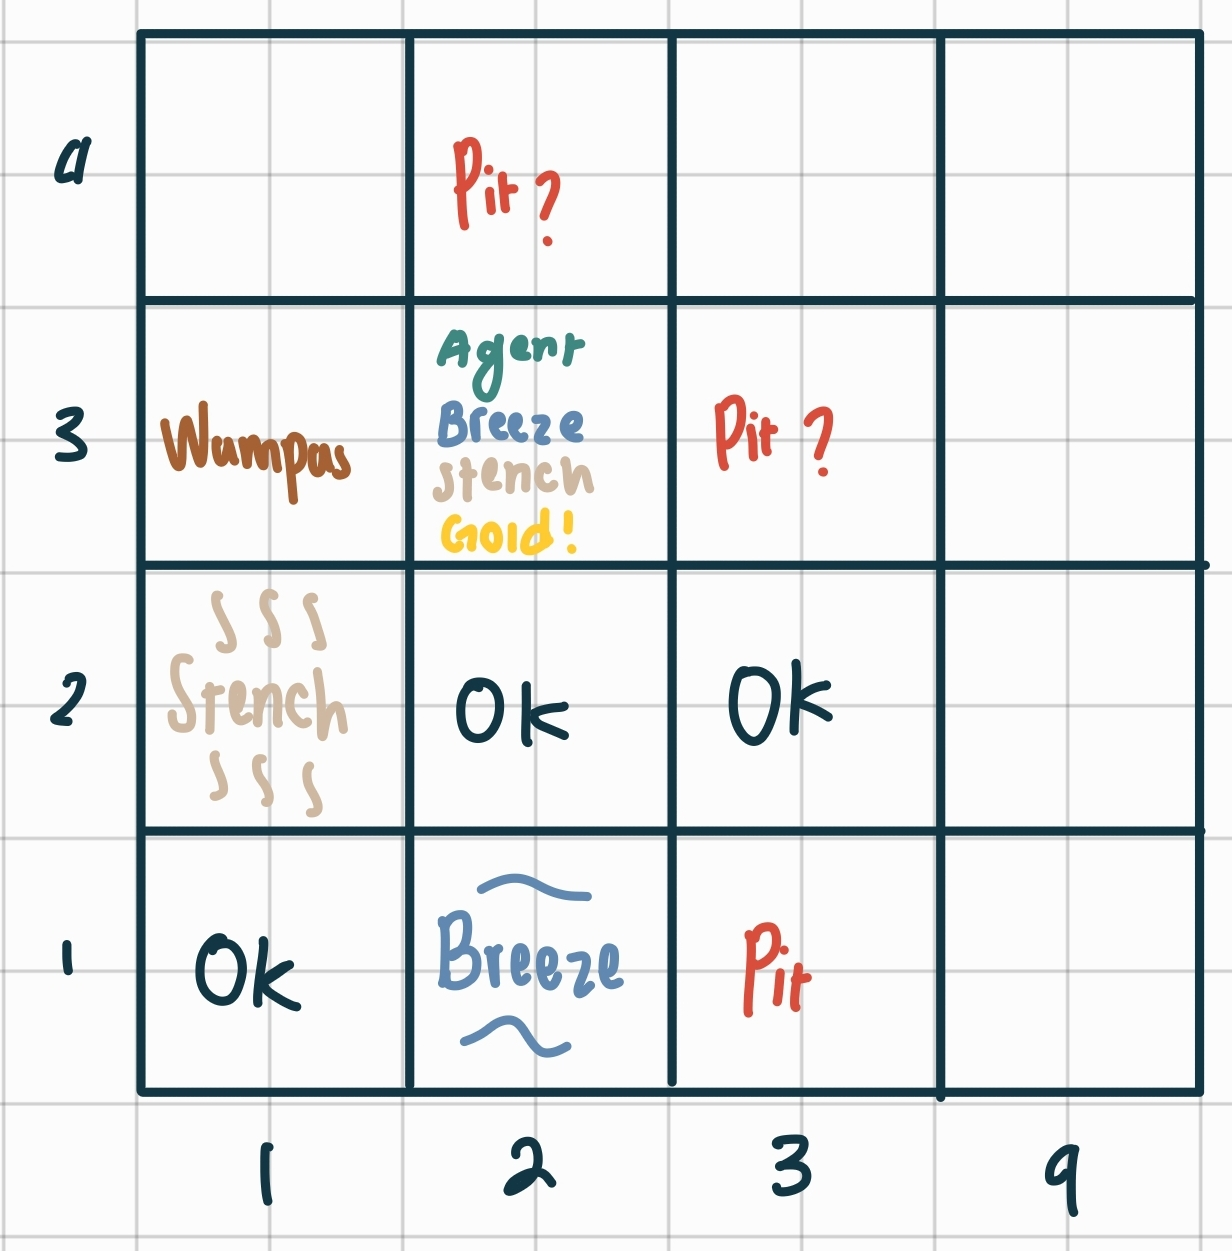

In [132]:
A23 = Image(filename='../Images/A23.jpg', width=200, height=200)
display(A23)

# 🙏🏻 Terimakasih 🙏🏻